Okay, so everything in this Jupyter notebook will be a call of other python files functions, and when I mean everything is that way, from the scraping to training the model and visualize the results, the only thing is that I will leave the scrapping part commented because it takes a lot of time to scrape everything, so if you are confused or don't understand please go to the .py files, here I will explain each file briefly:

1. scrape_data.py: This file scrapes all the data and introduce it into a DataFrame
2. pp_train.py: This file cleans, preprocess and organizes all the training data
3. pp_test.py: This file creates the test data for the model matching the same columns of the training data
4. transf_data.py: This file transform the training data in different ways, using historic averages and rolling averages
5. train_scale.py: This file scales the data and trains the data on a XGBoost model.
6. display_results.py: This file displays the results as it was a league.


-------------------------------------------------------------------------------------------------------------------------


Bien, todo en este Jupyter Notebook será una llamada a otras funciones de archivos de Python. Y cuando me refiero a que todo es así, desde el scraping hasta el entrenamiento del modelo y la visualización de los resultados, lo único es que dejaré la parte del scraping comentada, ya que scraping completo lleva mucho tiempo. Así que si tienes dudas o no lo entiendes, consulta los archivos .py. Aquí explicaré brevemente cada archivo:

1. scrape_data.py: Este archivo scrape_data.py: Este archivo scrape_data.py: Este archivo scrape_data.py: Este archivo extrae todos los datos y los introduce en un DataFrame.
2. pp_train.py: Este archivo limpia, preprocesa y organiza todos los datos de entrenamiento.
3. pp_test.py: Este archivo crea los datos de prueba para el modelo que coinciden con las mismas columnas de los datos de entrenamiento.
4. transf_data.py: Este archivo transforma los datos de entrenamiento de diferentes maneras, utilizando promedios históricos y promedios móviles.
5. train_scale.py: Este archivo escala los datos y los entrena en un modelo XGBoost. 
6. display_results.py: Este archivo muestra los resultados como si fuera una liga.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scrape_data
import pp_test 
import pp_train 
import transf_data 
import train_scale 

If you run this it could take more than an hour, so it's better just to use the dataset I built.


-------------------------------------------------------------------------------------------------

Si corres este codigo podria tardar mas de una hora, asi que es mejor que solo uses el dataset que ya construi

In [2]:
# all_data = scrape_data.get_data(['2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025'])
# print(scrape_data.test_complete_data(all_data))

In [3]:
complete_training_data = pd.read_csv('./Complete_datasets/Complete_LaLiga_Dataset.csv')
complete_test_data = pd.read_csv('./Complete_datasets/Test_Data_LaLiga25-26.csv')

Before preprocessing all the data, it's very important to understand that we need to test our model and iterate until getting to the best result as we can, so before using the training and testing, we are going to use the last season from the training set, that is the 2024-25 season as our validation set, we will try and see how good are we doing and then incorporate the last season to our training set and use the testing set.

---------------------------------------------------------------------------------

Antes de preprocesar todos los datos, es muy importante entender que necesitamos probar nuestro modelo e iterar hasta llegar al mejor resultado posible, así que antes de usar el entrenamiento y las pruebas, vamos a utilizar la última temporada del conjunto de entrenamiento, que es la temporada 2024-25 como nuestro conjunto de validación, intentaremos ver qué tan bien lo estamos haciendo y luego incorporaremos la última temporada a nuestro conjunto de entrenamiento y usaremos el conjunto de prueba.

In [4]:
train_data_1 = complete_training_data[complete_training_data['season'] < 2025]
validation_data_1 = complete_training_data[complete_training_data['season'] == 2025]

Let's take a look at the amount of data we have, each season every team plays 38 games and there are 20 teams playing in the league, so we should have
20 teams * 38 games played = 760 games per season. At this point we have 1 season on the validation data and the training data has 7 seasons worth of data, which means we should have 760 * 7 = 5320 games.

----------------------------------------------------------------

Analicemos la cantidad de datos que tenemos: cada temporada, cada equipo juega 38 partidos y hay 20 equipos en la liga, por lo que deberíamos tener 20 equipos * 38 partidos jugados = 760 partidos por temporada. En este punto, tenemos una temporada en los datos de validación y los datos de entrenamiento contienen datos de 7 temporadas, lo que significa que deberíamos tener 760 * 7 = 5320 partidos.

In [5]:
train_data_1.shape, validation_data_1.shape

((5320, 22), (760, 22))

Fine, now let's preprocess all the training and validation data.

---------------------------------------------

Bien, ahora procesemos toda la data de entrenamiento y validacion.

In [6]:
train_preprocess_obj = pp_train.full_preprocess(train_data_1, 'formation', 'date', 'round', ['venue', 'day'], 'result', 
                                                'team', 'opponent','xg', 'xga', 'poss', 'gf', 'ga', 'sot', 'sh')

pp_train_data_1 = train_preprocess_obj.run()

In [7]:
validation_data = pp_test.merge_all(train_data_1, validation_data_1, 'date', 'round', ['venue', 'day'], 'team', 'opponent',
                                    'formation', 'formation_defenders', 'formation_midfielders', 'formation_strikers', 'xg',
                                    'xga', 'poss', 'gf', 'ga', 'sot', 'sh', 'result', False)

Perfect, now that we have our raw training data and our validation data, it's time for transformations, the transf_data.py has the logic for the transformations. The next step is using each transformed dataset to train the model and see how good it performs in each, after that we will pick the data that gave the best results and use that for the test set. I will also compare how accurate was the prediction of the model with the real results of last year LaLiga's results.

----------------------------------------------------------

Perfecto, ahora que tenemos los datos de entrenamiento sin procesar y los de validación, es hora de realizar las transformaciones. El archivo transf_data.py contiene la lógica para las transformaciones. El siguiente paso es usar cada conjunto de datos transformado para entrenar el modelo y comprobar su rendimiento en cada uno. Después, seleccionaremos los datos con los mejores resultados y los usaremos para el conjunto de pruebas. También compararé la precisión de la predicción del modelo con los resultados reales de LaLiga del año pasado.

In [8]:
continuous_cols = ['gf', 'ga', 'xg', 'xga', 'poss', 'sot', 'sh', 'dist',
       'fk', 'pk', 'pkatt', 'xg_diff', 'poss_a', 'poss_diff',
       'effective_possesion', 'vulnerable_possesion', 'gf_ga_diff',
       'shooting_scoring_efficiency', 'shooting_efficiency']

In [9]:
raw_training_data = pp_train_data_1
historic_avg_data = transf_data.get_historical_by_season(pp_train_data_1, continuous_cols, 'team', 'season')
rolling_data = \
    pp_train_data_1.groupby('team').apply(lambda x: transf_data.get_rolling_averages(x, continuous_cols, 3, 'date')).droplevel(level=0, axis=0)

Perfect, now let's check out every dataset has the same amount of features so we can compare fairly

-----------------------------------------

Perfecto, ahora veamos si todos los dataset tienen la misma cantidad de inputs para poder comparar los modelos de manera adecuada.

In [10]:
check_features = lambda a, b, c: 'Passed' if a ==  b == c  else 'Failed'

check_features(raw_training_data.shape[1], historic_avg_data.shape[1], rolling_data.shape[1])

'Passed'

This is the deal, our validation data doesn't have the ELO rating, so we are going to train a model and prediict the results and then on that result we are going to calculate the ELO rating, once the ELO rating is on the validation data, we are going to train our model again and predict using the new features. So let's first scale our data and then feed it into the model (we are going to train 3 different models and see which one is better). First let's split between X and y and then scale.

--------------------

Ahora es el momento de entrenar el modelo con cada tipo de transformación de datos, así que primero escalemos nuestros datos y luego los alimentemos al modelo (vamos a entrenar 3 modelos diferentes y veremos cuál es mejor)

In [11]:
training_features = ['gf', 'ga', 'xg', 'xga', 'poss',
                     'sot', 'sh', 'dist', 'fk', 'pk', 'pkatt', 'xg_diff', 'poss_a',
                     'poss_diff', 'effective_possesion', 'vulnerable_possesion',
                     'gf_ga_diff', 'shooting_scoring_efficiency', 'shooting_efficiency',
                     'result', 'month', 'played_first_part_of_month', 'home_team_encoded', 
                     'opponent_team_encoded', 'played_second_part_of_month', 'round_encoded', 
                     'is_first_round', 'is_second_round', 'day_Fri', 'day_Mon', 'day_Sat', 'day_Sun',
                     'day_Thu', 'day_Tue', 'day_Wed', 'venue_Away', 'venue_Home', 'formation_defenders',
                     'formation_midfielders', 'formation_strikers']

cont_cols = training_features[:19]
cat_cols = training_features[20:]

raw_training_data = raw_training_data[training_features]
historic_avg_data = historic_avg_data[training_features]
rolling_data = rolling_data[training_features]

In [12]:
def split_X_y(train_data:pd.DataFrame, test_data:pd.DataFrame, target:str):

    X_train = train_data.drop(target, axis=1)
    y_train = train_data[target]

    X_test = test_data.drop(target, axis=1)
    y_test = test_data[target]

    return X_train, y_train, X_test, y_test

In [13]:
X_raw_train, y_raw_train, X_test, y_test = split_X_y(raw_training_data, validation_data, 'result')
X_historic_train, y_historic_train, _, _ = split_X_y(historic_avg_data, validation_data, 'result')
X_rolling_train, y_rolling_train, _, _ = split_X_y(rolling_data, validation_data, 'result')

In [14]:
X_raw_train_scaled, X_test_scaled = train_scale.scale_data(X_raw_train, X_test, cont_cols, cat_cols) 
X_historic_train_scaled, _ = train_scale.scale_data(X_historic_train, X_test, cont_cols, cat_cols) 
X_rolling_train_scaled, _ = train_scale.scale_data(X_rolling_train, X_test, cont_cols, cat_cols)

Now let's train each model and see what we get.

--------------------------------------------------

Entrenemos cada modelo y veamos que conseguimos.

Fitting 1 folds for each of 1728 candidates, totalling 1728 fits
--- Best Hyperparameters Found ---
{'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'random_state': 1, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'subsample': 0.8}

--- Classification Report on Validation Set ---
              precision    recall  f1-score   support

           0       0.52      0.39      0.45       114
           1       0.37      0.07      0.12        97
           2       0.52      0.85      0.65       169

    accuracy                           0.52       380
   macro avg       0.47      0.44      0.41       380
weighted avg       0.48      0.52      0.45       380




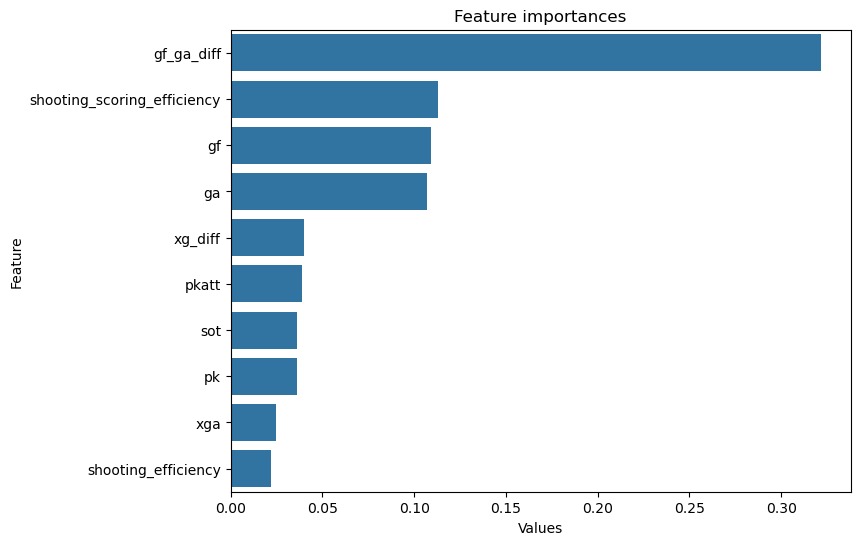

In [44]:
best_raw_model, best_raw_params, raw_feature_imp, raw_y_pred, raw_y_pred_proba =\
      train_scale.train_and_evaluate_xgb(X_raw_train_scaled, y_raw_train, X_test_scaled, y_test)

Fitting 1 folds for each of 1728 candidates, totalling 1728 fits
--- Best Hyperparameters Found ---
{'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'random_state': 1, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8}

--- Classification Report on Validation Set ---
              precision    recall  f1-score   support

           0       0.69      0.68      0.68       114
           1       0.78      0.32      0.45        97
           2       0.65      0.88      0.75       169

    accuracy                           0.68       380
   macro avg       0.71      0.63      0.63       380
weighted avg       0.70      0.68      0.65       380




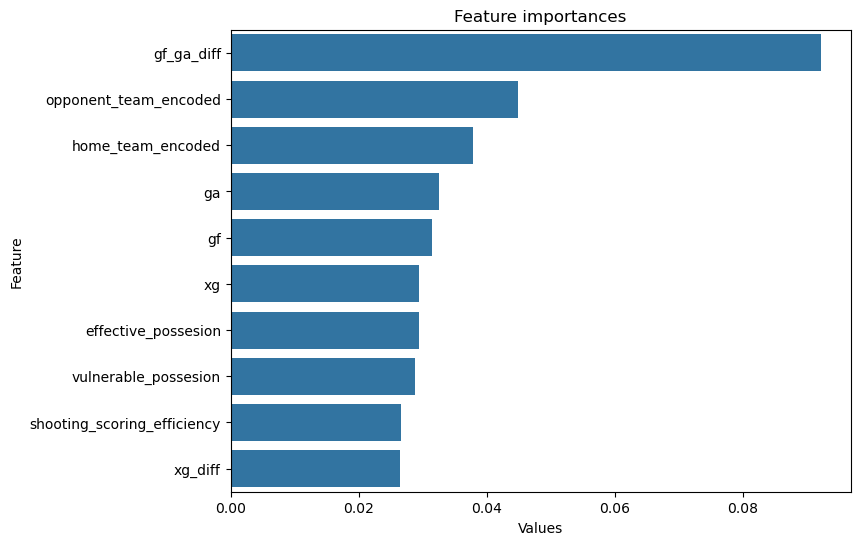

In [15]:
best_historic_model, best_historic_params, historic_feature_imp, historic_y_pred, historic_y_pred_prob =\
      train_scale.train_and_evaluate_xgb(X_historic_train_scaled, y_historic_train, X_test_scaled, y_test)

Fitting 1 folds for each of 1728 candidates, totalling 1728 fits
--- Best Hyperparameters Found ---
{'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'random_state': 1, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8}

--- Classification Report on Validation Set ---
              precision    recall  f1-score   support

           0       0.66      0.61      0.63       114
           1       0.74      0.36      0.49        97
           2       0.64      0.86      0.73       169

    accuracy                           0.66       380
   macro avg       0.68      0.61      0.62       380
weighted avg       0.67      0.66      0.64       380




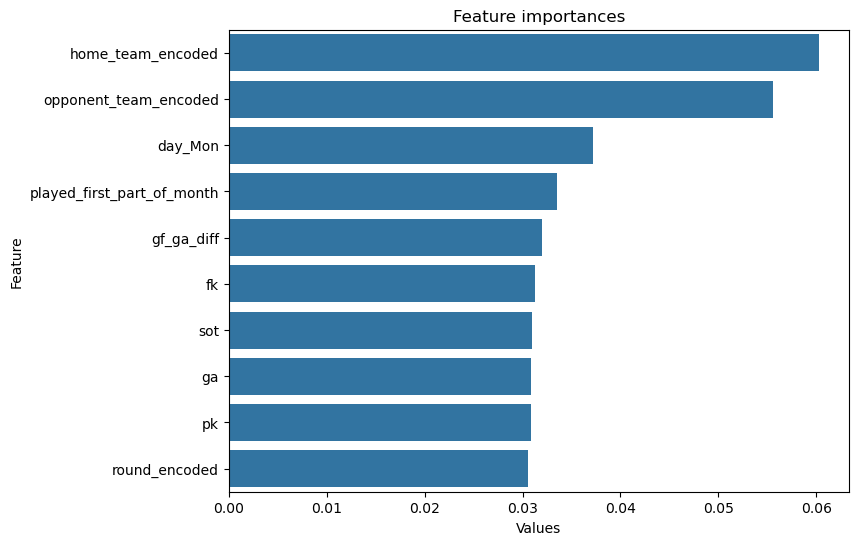

In [33]:
best_rolling_model, best_rolling_params, rolling_feature_imp, rolling_y_pred, rolling_y_pred_prob =\
      train_scale.train_and_evaluate_xgb(X_rolling_train_scaled, y_rolling_train, X_test_scaled, y_test)

The data that gave the best results was the historic data, it probably is because the validation set also contains historic data. So the next thing we would do is based on that prediction we are going to add an ELO feature to the dataset for each team, the home team and the away team, the training data already has this feature. This should give more information to the model, so let's see.

----------------------------

Los datos que arrojaron los mejores resultados fueron los históricos, probablemente porque el conjunto de validación también contiene datos históricos. A continuación, basándonos en esa predicción, añadiremos una función ELO al conjunto de datos para cada equipo, tanto el local como el visitante. Los datos de entrenamiento ya cuentan con esta función. Esto debería aportar más información al modelo, así que veamos.

In [16]:
X_test['result'] = y_test
X_test['hist_y_pred'] = historic_y_pred

In [17]:
def get_elo(df, team_col, opponent_col, result_col):

    elo_history = []
    elo = {team: 1500 for team in df[team_col].unique().tolist()}
    K = 20
    home_adv = 100

    for idx, row in df.iterrows():
        home, away = row[team_col], row[opponent_col]
        home_elo, away_elo = elo[home], elo[away]

        expected_home = 1 / (1 + 10 ** (((away_elo + home_adv) - home_elo) / 400))

        if row[result_col] == 2:
            score_home = 1
        elif row[result_col] == 1:
            score_home = 0.5
        else:
            score_home = 0

        delta = K * (score_home - expected_home)
        elo[home] += delta
        elo[away] -= delta

        elo_history.append({
            'date': row['date'],
            'home_team': home,
            'away_team': away,
            'elo_home': home_elo,
            'elo_away': away_elo,
            'elo_diff': home_elo - away_elo
        })

    elos_df = pd.DataFrame(elo_history)
    df = df.reset_index().drop(columns='index', axis=1)
    complete_data = df.join(elos_df[['elo_home', 'elo_away', 'elo_diff']])

    return complete_data

In [18]:
X_test2 = get_elo(X_test, 'team', 'opponent', 'hist_y_pred')

Now that we have our ELOs features, let's train the model again and see if there is an increase on the f1-score.

---------------------------------

Ahora que tenemos nuestras características ELO, entrenemos el modelo nuevamente y veamos si hay un aumento en el puntaje f1.

In [19]:
historic_avg_data2 = transf_data.get_historical_by_season(pp_train_data_1, continuous_cols, 'team', 'season')

training_features = training_features + ['elo_home', 'elo_away', 'elo_diff']

X_historic_train2 = historic_avg_data2[training_features]
X_historic_train2 = X_historic_train2.drop(columns='result', axis=1)
X_test2 = X_test2.drop('result', axis=1)

In [20]:
X_historic_train_scaled2, X_test_scaled2 = train_scale.scale_data(X_historic_train2, X_test2, cont_cols + ['elo_home', 'elo_away', 'elo_diff'], cat_cols) 

Fitting 1 folds for each of 1728 candidates, totalling 1728 fits
--- Best Hyperparameters Found ---
{'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'random_state': 1, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.8}

--- Classification Report on Validation Set ---
              precision    recall  f1-score   support

           0       0.49      0.69      0.58       114
           1       0.50      0.04      0.08        97
           2       0.60      0.75      0.67       169

    accuracy                           0.55       380
   macro avg       0.53      0.50      0.44       380
weighted avg       0.54      0.55      0.49       380




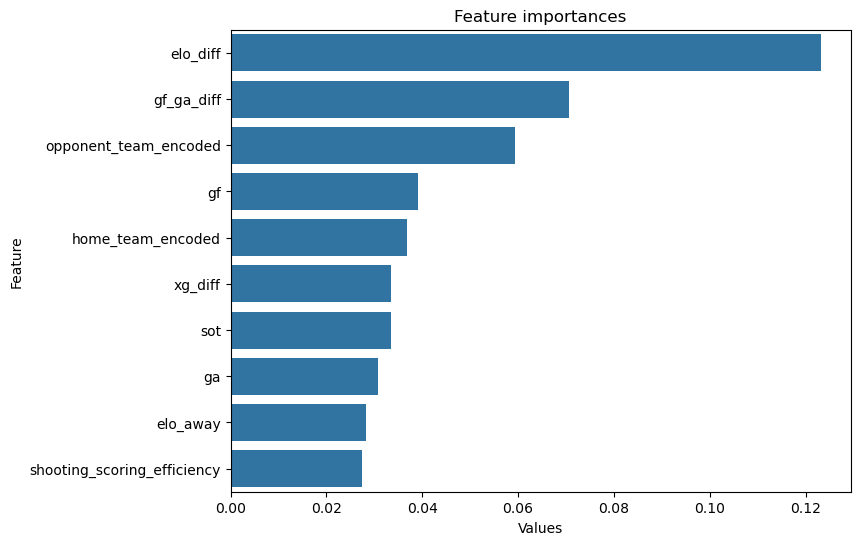

In [21]:
best_historic_model2, best_historic_params2, historic_feature_imp2, historic_y_pred2, historic_y_pred_prob2 =\
      train_scale.train_and_evaluate_xgb(X_historic_train_scaled2, y_historic_train, X_test_scaled2, y_test)

The ELO ratings just made the predictions worse, so we are not going to use it.

-----------------------

Las clasificaciones ELO empeoraron las predicciones, así que no las usaremos. 

Below I will put a photo of the real outcome of the competition, and below we will compare the model's prediction with the reality.

---------------------------------------

A continuación pondré una foto del resultado real de la competición, y más abajo compararemos la predicción del modelo con la realidad.

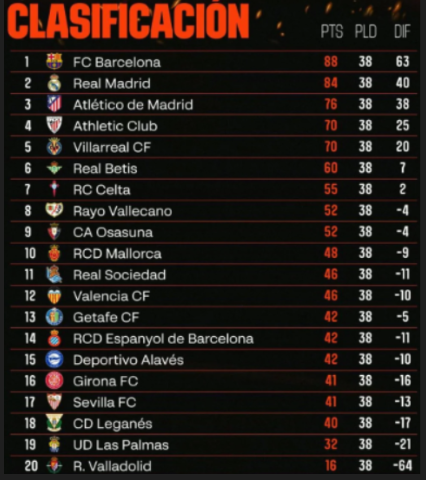

Let's see how the table would look if we apply the predictions of the model.

--------------------------------------------------

Veamos como se vería la tabla si aplicamos las predicciones del modelo.

In [22]:
def add_results(result):
    if result == 2:
        return 3, 0
    elif result == 1:
        return 1, 1
    else:
        return 0, 3


def display_league(X_test, team_col, opponent_col, y_pred_col):

    scores = {team:0 for team in list(set(X_test[team_col].unique().tolist() + X_test[opponent_col].unique().tolist()))}

    for team, opponent, res in zip(X_test[team_col], X_test[opponent_col], X_test[y_pred_col]):
        home_points, away_points = add_results(res)
        
        scores[team] += home_points
        scores[opponent] += away_points

    scores = sorted(scores.items(), key=lambda item: item[1], reverse=True)

    return scores


scores_upd_hist = display_league(X_test, 'team', 'opponent', 'hist_y_pred')

Is not bad, but there are some things that look non-realistic, it seems like the model predicts that Barcelona and Real Madrid may win all their matches, and that Valladolid and Las Palmas will only win 2 and 4 games respectively. For this issue, we are going to use isotonic regression to change the probabilities of each class choosen by the model and make it more real, this will help us to prevent the model predicting things like Barcelona will win all his matches. The way we do it is we train a model to calibrate each columna of probabilities, one for the Loss or class 0, another one for the draws or class 1 and another one for class 2 or the Wins.

-------------------------------------------

No está mal, pero hay algunas cosas que no parecen realistas, parece que el modelo predice que Barcelona y Real Madrid pueden ganar todos sus partidos, y que Valladolid y Las Palmas solo ganarán 2 y 4 partidos respectivamente. Para este problema, usaremos regresión isotónica para modificar las probabilidades de cada clase elegida por el modelo y hacerlas más realistas. Esto nos ayudará a evitar que el modelo prediga cosas como que el Barcelona ganará todos sus partidos. Para ello, entrenamos un modelo para calibrar cada columna de probabilidades: una para la derrota (clase 0), otra para los empates (clase 1) y otra para la clase 2 (victorias).

In [23]:
from sklearn.isotonic import IsotonicRegression

def apply_isotonic_probs(train_pred: np.array, train_pred_proba: np.array, test_pred: np.array, test_pred_proba: np.array):

    isos = []
    for k in range(train_pred_proba.shape[1]):
        iso = IsotonicRegression(out_of_bounds='clip')
        iso.fit(train_pred_proba[:, k], (train_pred == k).astype(int))
        isos.append(iso) 

    isotonic_preds = np.column_stack([isos[k].predict(test_pred_proba[:, k]) for k in range(test_pred_proba.shape[1])]) 

    # Here we recalculate each probability.

    isotonic_preds /= isotonic_preds.sum(axis=1, keepdims=True)

    new_preds = []

    for row_n in range(isotonic_preds.shape[0]):
        new_preds.append(np.argmax(isotonic_preds[row_n, :]))

    return isotonic_preds, new_preds 

In [24]:
historic_y_train_pred_proba = best_historic_model.predict_proba(X_historic_train_scaled)
historic_y_train_pred = best_historic_model.predict(X_historic_train_scaled)

In [25]:
isotonic_preds, new_preds = apply_isotonic_probs(historic_y_train_pred, historic_y_train_pred_proba, historic_y_pred, historic_y_pred_prob)

In [26]:
X_test['isotonic_pred'] = new_preds

In [27]:
scores_upd_hist_isotonic = display_league(X_test, 'team', 'opponent', 'isotonic_pred')
scores_upd_hist_isotonic

[('Barcelona', 111),
 ('Real Madrid', 103),
 ('Atletico Madrid', 98),
 ('Athletic Club', 80),
 ('Villarreal', 78),
 ('Real Sociedad', 62),
 ('Osasuna', 60),
 ('Celta Vigo', 60),
 ('Real Betis', 57),
 ('Valencia', 55),
 ('Sevilla', 54),
 ('Espanyol', 47),
 ('Rayo Vallecano', 44),
 ('Girona', 43),
 ('Mallorca', 40),
 ('Getafe', 34),
 ('Leganes', 31),
 ('Alaves', 29),
 ('Las Palmas', 12),
 ('Valladolid', 6)]

There isn't a big difference, so now let's change the perspective, instead of predicting win, draw or loss, let's predict goals from the home team and the away team using the same data.

In [28]:
y_train_multi = pp_train_data_1[['gf', 'ga']]
X_historic_train_scaled_multi = X_historic_train_scaled.drop(columns=['gf', 'ga', 'gf_ga_diff'], axis=1)
X_test_multi = X_test_scaled.drop(columns=['gf', 'ga', 'gf_ga_diff'], axis=1)
y_test_multi = validation_data_1[validation_data_1['venue'] == 'Home'].sort_values(by='date')[['gf', 'ga']]

In [29]:
best_historic_model_multi, best_historic_params_multi, historic_feature_imp_multi, historic_y_pred_multi, historic_y_pred_prob_multi =\
      train_scale.train_and_evaluate_xgb(X_historic_train_scaled_multi, y_train_multi, X_test_multi, y_test_multi, multi_output=True)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
--- Best Hyperparameters Found ---
{'estimator__colsample_bytree': 0.8, 'estimator__eta': 0.05, 'estimator__eval_metric': 'poisson-nloglik', 'estimator__max_depth': 6, 'estimator__objective': 'count:poisson', 'estimator__subsample': 0.8}

--- Classification Report on Validation Set ---


In [30]:
from sklearn.metrics import classification_report

print('Classification Report for home goals scored: \n')
print(classification_report(y_test_multi['gf'], historic_y_pred_multi[:, 0]))

Classification Report for home goals scored: 

              precision    recall  f1-score   support

         0.0       0.85      0.42      0.56        79
         1.0       0.52      0.98      0.68       156
         2.0       0.76      0.24      0.37        79
         3.0       1.00      0.16      0.27        38
         4.0       0.94      0.68      0.79        22
         5.0       0.00      0.00      0.00         3
         7.0       0.00      0.00      0.00         3

    accuracy                           0.59       380
   macro avg       0.58      0.35      0.38       380
weighted avg       0.70      0.59      0.54       380



In [31]:
print('Classification Report for home goals scored: \n')
print(classification_report(y_test_multi['ga'], historic_y_pred_multi[:, 1]))

Classification Report for home goals scored: 

              precision    recall  f1-score   support

         0.0       0.68      0.65      0.66       116
         1.0       0.59      0.87      0.70       142
         2.0       0.76      0.48      0.59        81
         3.0       1.00      0.14      0.24        29
         4.0       1.00      0.50      0.67         8
         5.0       1.00      0.50      0.67         4

    accuracy                           0.65       380
   macro avg       0.84      0.52      0.59       380
weighted avg       0.70      0.65      0.63       380



The accuracy of the model keeps being the same, so let's see how much the classification table changes.

-----------------------

La precisión del modelo sigue siendo la misma, así que veamos cuánto cambia la tabla de clasificación.

In [32]:
X_test['multi_gf_pred'] = historic_y_pred_multi[:, 0]
X_test['actual_multi_gf'] = y_test_multi['gf']
X_test['multi_ga_pred'] = historic_y_pred_multi[:, 1]
X_test['actual_multi_ga'] = y_test_multi['ga']

In [33]:
def add_results2(gf, ga):
    if gf > ga:
        home_points, away_points = 3, 0
    elif gf == ga:
        home_points, away_points = 1, 1
    else:
        home_points, away_points = 0, 3

    return home_points, away_points

def display_league2(X_test, team_col, opponent_col, gf_pred, ga_pred):

    scores = {team:0 for team in list(set(X_test[team_col].unique().tolist() + X_test[opponent_col].unique().tolist()))}

    for team, opponent, gf, ga in zip(X_test[team_col], X_test[opponent_col], X_test[gf_pred], X_test[ga_pred]):
        home_points, away_points = add_results2(gf, ga)
        
        scores[team] += home_points
        scores[opponent] += away_points

    scores = sorted(scores.items(), key=lambda item: item[1], reverse=True)

    return scores

In [34]:
scores_multi = display_league2(X_test, 'team', 'opponent', 'multi_gf_pred', 'multi_ga_pred')
scores_multi

[('Barcelona', 99),
 ('Real Madrid', 90),
 ('Atletico Madrid', 82),
 ('Athletic Club', 64),
 ('Valencia', 58),
 ('Sevilla', 54),
 ('Real Sociedad', 46),
 ('Villarreal', 44),
 ('Girona', 43),
 ('Celta Vigo', 42),
 ('Alaves', 40),
 ('Rayo Vallecano', 39),
 ('Getafe', 38),
 ('Real Betis', 37),
 ('Espanyol', 35),
 ('Osasuna', 32),
 ('Leganes', 28),
 ('Valladolid', 27),
 ('Las Palmas', 26),
 ('Mallorca', 26)]

As you can see, this is way more realistic, the model keeps making some mistakes like Real Sociedad in the 16th place. The last touch is making a Monte Carlo simulation, this is ideal for this case because it will simulate thousands of random outcomes using the actual expectation, and that will normalize or add a little bit more of realism to the prediction, after randomly selecting an outcome 5000 times using the actual prediction and then taking the mean of that will give you a more realistic scenario in which the champion can also lose or draw. For this we are going to use a function that runs n_simulations times and it will take the actual prediction and based on that pick a random number that follows a Poisson distribtion, this will introduce uncertainty that we didn't have before.

------------------------------------------------------------

Como pueden ver, esto es mucho más realista. El modelo sigue cometiendo algunos errores, como el de la Real Sociedad en el puesto 16. El último paso consiste en realizar una simulación de Monte Carlo, ideal para este caso, ya que simulará miles de resultados aleatorios utilizando la predicción real. Esto normalizará la predicción y le añadirá mayor realismo. Tras seleccionar aleatoriamente un resultado 5000 veces usando la predicción real y analizar su significado, se obtiene un escenario más realista en el que el campeón también puede perder o empatar. Para ello, utilizaremos una función que se ejecuta n_simulations veces. Esta función tomará la predicción real y, basándose en ella, elegirá un número aleatorio que sigue una distribución de Poisson, lo que introducirá una incertidumbre que antes no teníamos.

In [35]:
from scipy.stats import poisson
from tqdm import trange

'''
    THIS IS THE ITERATIVE WAY AND HONESTLY IT IS TOO SLOW, INSTEAD TRY THE VECTORIZED ONE BELOW
    FOR SPEED, WHAT TAKES 20 MINUTES HERE, TAKES LESS THAN A SECOND IN THE OTHER. THE ITERATIVE
    APPROACH IS FOR YOU TO UNDERSTAND WHAT'S GOING ON BECAUSE THE VECTORIZED ONE MAY BE A LITTLE
    BIT ABSTRACT
'''

# def simulate_montecarlo(df_preds, home_team_col, away_team_col, gf_pred_col, ga_pred_col, n_simulations=5000):

#     teams = sorted(df_preds['team'].unique().tolist())
#     results = {team:[] for team in teams}

#     for sim in trange(n_simulations, desc='Simulating seasons'):

#         points = {team:0 for team in teams}

#         for _, row in df_preds.iterrows():
#             h = row[home_team_col]
#             a = row[away_team_col]
        
#             lam_h = max(row[gf_pred_col], 0.1)
#             lam_a = max(row[ga_pred_col], 0.1)

#             gh = poisson.rvs(lam_h)
#             ga = poisson.rvs(lam_a)

#             if gh > ga:
#                 points[h] += 3
#             elif gh == ga:
#                 points[h] += 1
#                 points[a] += 1
#             else:
#                 points[a] += 3

#         for team in teams:
#             results[team].append(points[team])

#     summary = pd.DataFrame({
#         'team': teams,
#         'mean_points': [np.mean(results[t]) for t in teams],
#         'p10': [np.percentile(results[t], 10) for t in teams],
#         'p50': [np.percentile(results[t], 50) for t in teams],
#         'p90': [np.percentile(results[t], 90) for t in teams],
#         'prob_champion': [
#             np.mean(np.array(results[t]) == np.max([results[x] for x in teams], axis=0))
#             for t in teams
#         ]
#     }).sort_values('mean_points', ascending=False).reset_index(drop=True)

#     return summary, results

# summary_MC, results_MC = simulate_montecarlo(X_test, 'team', 'opponent', 'multi_gf_pred', 'multi_ga_pred', 10000)


"\n    THIS IS THE ITERATIVE WAY AND HONESTLY IT IS TOO SLOW, INSTEAD TRY THE VECTORIZED ONE BELOW\n    FOR SPEED, WHAT TAKES 20 MINUTES HERE, TAKES LESS THAN A SECOND IN THE OTHER. THE ITERATIVE\n    APPROACH IS FOR YOU TO UNDERSTAND WHAT'S GOING ON BECAUSE THE VECTORIZED ONE MAY BE A LITTLE\n    BIT ABSTRACT\n"

In [36]:
import numpy as np
import pandas as pd
from scipy.stats import poisson

def simulate_montecarlo_vect(df_preds, home_team_col, away_team_col, gf_pred_col, ga_pred_col, n_simulations=10000):
    """
    df_preds: DataFrame con columnas ['home_team', 'away_team', 'pred_home_goals', 'pred_away_goals']
    n_simulations: número de temporadas simuladas
    """
    np.random.seed(123)

    teams = sorted(list(set(df_preds[home_team_col]) | set(df_preds[away_team_col])))

    # 1️⃣ Extraer los goles predecidos por el modelo
    lam_h = np.clip(df_preds[gf_pred_col].values, 0.1, None)
    lam_a = np.clip(df_preds[ga_pred_col].values, 0.1, None)
    n_matches = len(df_preds)

    # 2️⃣ Simular goles para todas las simulaciones de una vez usando poisson
    # Matrices (n_matches x n_simulations)
    home_goals_sim = poisson.rvs(lam_h[:, None], size=(n_matches, n_simulations))
    away_goals_sim = poisson.rvs(lam_a[:, None], size=(n_matches, n_simulations))

    # 3️⃣ Determinar resultados
    home_win = (home_goals_sim > away_goals_sim).astype(int)
    draw = (home_goals_sim == away_goals_sim).astype(int)
    away_win = (home_goals_sim < away_goals_sim).astype(int)

    # 4️⃣ Calcular puntos por partido (para local y visitante)
    points_home = 3 * home_win + 1 * draw
    points_away = 3 * away_win + 1 * draw

    # 5️⃣ Acumular puntos totales por equipo
    team_points = {t: np.zeros(n_simulations, dtype=int) for t in teams}

    for i, row in df_preds.reset_index().iterrows():
        h, a = row[home_team_col], row[away_team_col]
        team_points[h] += points_home[i, :]
        team_points[a] += points_away[i, :]

    # TE QUEDASTE AQUI

    # 6️⃣ Crear resumen estadístico
    all_points = np.array([team_points[t] for t in teams])  # shape: (n_teams, n_simulations)
    max_points_per_sim = all_points.max(axis=0)

    summary = pd.DataFrame({
        'team': teams,
        'mean_points': np.mean(all_points, axis=1),
        'p10': np.percentile(all_points, 10, axis=1),
        'p50': np.percentile(all_points, 50, axis=1),
        'p90': np.percentile(all_points, 90, axis=1),
        'prob_champion': np.mean(all_points == max_points_per_sim, axis=1)
    }).sort_values('mean_points', ascending=False).reset_index(drop=True)

    summary.index = [i + 1 for i in range(20)]

    summary['position'] = np.zeros(20)

    for ind in summary.index:
        if ind == 1:
            summary.loc[ind, 'position'] = 'Champion'
        elif ind in [2, 3, 4, 5]:
            summary.loc[ind, 'position'] = 'Champions League'
        elif ind in [6, 7]:
            summary.loc[ind, 'position'] = 'Europa League'
        elif ind == 8:
            summary.loc[ind, 'position'] = 'Conference League'
        elif ind in [18, 19, 20]:
            summary.loc[ind, 'position'] = 'Relegation'
        else:
            summary.loc[ind, 'position'] = 'None'
         
    return summary, team_points

In [37]:
summary_MC, results_MC = simulate_montecarlo_vect(X_test, 'team', 'opponent', 'multi_gf_pred', 'multi_ga_pred', 10000)
summary_MC

,team,mean_points,p10,p50,p90,prob_champion,position
1,Barcelona,81.0181,73.0,81.0,89.0,0.5066,Champion
2,Real Madrid,80.6114,73.0,81.0,89.0,0.4720,Champions League
3,Atletico Madrid,71.6296,63.0,72.0,80.0,0.0737,Champions League
4,Athletic Club,59.3779,50.0,59.0,69.0,0.0017,Champions League
5,Valencia,57.2209,48.0,57.0,66.0,0.0015,Champions League
6,Sevilla,54.6262,46.0,55.0,64.0,0.0005,Europa League
7,Villarreal,53.6056,44.0,54.0,63.0,0.0002,Europa League
8,Girona,49.6460,41.0,49.0,58.0,0.0000,Conference League
9,Celta Vigo,48.9861,40.0,49.0,58.0,0.0000,None
10,Real Sociedad,47.2852,39.0,47.0,56.0,0.0000,None


So this is what our prediction will look like, Barcelona would have been the champion for las season, which is correct, Real Madrid, Atletico Madrid and Athletic Bilbao also were correct, the relegation part has 2/3 correct which is fine and the rest of the table has some mistakes but is okay because we are interested on the champion. So now we have to repeat the same process but with the test set, which has no way of validating if it's true, so my idea is creating a function that does everything we did instead of repeating the process.

-------------------------

Así que nuestra predicción sería la siguiente: el Barcelona habría sido campeón la temporada pasada, lo cual es correcto; Real Madrid, Atlético de Madrid y Athletic de Bilbao también acertaron; la parte del descenso tiene dos tercios de acierto, lo cual está bien. El resto de la tabla tiene algunos errores, pero no importa porque nos interesa el campeón. Ahora tenemos que repetir el mismo proceso, pero con el conjunto de prueba, que no tiene forma de validar si es cierto. Por eso, mi idea es crear una función que haga todo lo que hicimos en lugar de repetir el proceso.

In [38]:
def complete_pipeline(training_data: pd.DataFrame, testing_data: pd.DataFrame):

   y_train = training_data[training_data['venue'] == 'Home'].sort_values(by='date')[['gf', 'ga']]
   y_train = y_train

   train_preprocess_obj = pp_train.full_preprocess(training_data, 'formation', 'date', 'round', ['venue', 'day'], 'result', 
                                                'team', 'opponent','xg', 'xga', 'poss', 'gf', 'ga', 'sot', 'sh')

   train_data = train_preprocess_obj.run()

   test_data = pp_test.merge_all(train_data, testing_data, 'date', 'round', ['venue', 'day'], 'team', 'opponent',
                                    'formation', 'formation_defenders', 'formation_midfielders', 'formation_strikers', 'xg',
                                    'xga', 'poss', 'gf', 'ga', 'sot', 'sh', 'result', True)
   
   train_data = train_data.drop(['formation_defenders', 'formation_midfielders', 'formation_strikers'], axis=1)

    
   continuous_cols = ['gf', 'ga', 'xg', 'xga', 'poss', 'sot', 'sh', 'dist',
       'fk', 'pk', 'pkatt', 'xg_diff', 'poss_a', 'poss_diff',
       'effective_possesion', 'vulnerable_possesion', 'gf_ga_diff',
       'shooting_scoring_efficiency', 'shooting_efficiency']
    
   train_data = transf_data.get_historical_by_season(train_data, continuous_cols, 'team', 'season')

   training_features = ['gf', 'ga', 'xg', 'xga', 'poss',
                     'sot', 'sh', 'dist', 'fk', 'pk', 'pkatt', 'xg_diff', 'poss_a',
                     'poss_diff', 'effective_possesion', 'vulnerable_possesion',
                     'shooting_scoring_efficiency', 'shooting_efficiency',
                     'month', 'played_first_part_of_month', 'home_team_encoded', 
                     'opponent_team_encoded', 'played_second_part_of_month', 'round_encoded', 
                     'is_first_round', 'is_second_round', 'day_Fri', 'day_Mon', 'day_Sat', 'day_Sun',
                     'day_Thu', 'day_Tue', 'day_Wed', 'venue_Away', 'venue_Home']

   cont_cols = training_features[2:18]
   cat_cols = training_features[18:]

   train_data = train_data[training_features]
   test_data_feat = test_data[training_features]

   X_train, _, X_test, _= split_X_y(train_data, test_data_feat, ['gf', 'ga'])
   X_train_scaled, X_test_scaled = train_scale.scale_data(X_train, X_test, cont_cols, cat_cols)

   y_pred = train_scale.train_and_evaluate_xgb(X_train_scaled, y_train, X_test_scaled, _, multi_output=True, test_set=True)
   
   test_data = test_data.reset_index(drop=True).join(pd.DataFrame(y_pred, columns=['pred_gf', 'pred_ga']))

   simulation_league, results_league = simulate_montecarlo_vect(test_data, 'team', 'opponent', 'pred_gf', 'pred_ga')

   results_without_sim = display_league2(test_data, 'team', 'opponent', 'pred_gf', 'pred_ga')
   results_without_sim = pd.DataFrame(results_without_sim, columns=['team', 'points'], index=[i + 1 for i in range(20)])
   results_without_sim.index.name = 'Position'

   return simulation_league, results_league, results_without_sim, test_data

In [39]:
final_training_data = complete_training_data
final_testing_data = complete_test_data

In [40]:
simulated_league, results_league, results_without_sim, test_set = complete_pipeline(final_training_data, final_testing_data)

In [41]:
simulated_league

,team,mean_points,p10,p50,p90,prob_champion,position
1,Barcelona,81.4091,73.0,81.0,89.0,0.5669,Champion
2,Real Madrid,80.1492,72.0,80.0,88.0,0.4582,Champions League
3,Atletico Madrid,65.6501,57.0,66.0,74.0,0.0159,Champions League
4,Valencia,62.8964,55.0,63.0,71.0,0.0054,Champions League
5,Villarreal,60.2416,52.0,60.0,69.0,0.0021,Champions League
6,Real Betis,57.8514,50.0,58.0,66.0,0.0003,Europa League
7,Athletic Club,51.2825,43.0,51.0,60.0,0.0001,Europa League
8,Girona,51.0163,42.0,51.0,60.0,0.0000,Conference League
9,Sevilla,50.1284,42.0,50.0,59.0,0.0000,None
10,Celta Vigo,49.7716,41.0,50.0,58.0,0.0000,None


In [42]:
results_without_sim

,team,points
Position,,
1,Barcelona,94
2,Real Madrid,90
3,Atletico Madrid,73
4,Valencia,67
5,Villarreal,65
6,Real Betis,59
7,Girona,53
8,Athletic Club,52
9,Rayo Vallecano,50


So this is the prediction of the model, it says that for this season Barcelona has a 56% chance of winning while Real Madrid being the second contender has around 45% chance of winning it, on the other side, Alaves, Oviedo and Elche are expected to be relegated, and last, the teams hat will qualify for Champions League will be Barcelona, Real Madrid, Atletico Madrid, Valencia and Villarreal, the ones that will qualify to Europa League will be Real Betis and Athletic Bilbao, and last, the team that will qualify for Conference League will be Girona. The only way to know how accurate this was is just waiting for the season to finish.

--------------------------------------

Según el modelo, esta temporada el Barcelona tiene un 56% de probabilidades de ganar, mientras que el Real Madrid, segundo aspirante, tiene alrededor de un 45%. Por otro lado, se espera que Alavés, Oviedo y Elche desciendan. Finalmente, los equipos que se clasificarán para la Champions League serán Barcelona, ​​Real Madrid, Atlético de Madrid, Valencia y Villarreal; los que se clasificarán para la Europa League serán el Real Betis y el Athletic Club; y el Girona, que se clasificará para la Conference. La única forma de saber si este modelo es preciso es esperar a que termine la temporada.